# ML

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import matplotlib_venn as vn
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.legend_handler import HandlerTuple

from numpy.random import seed
seed(1)

colVals = ['tab:blue', 'tab:orange', 'tab:green', 'tab:gray']

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


As an exemplar ML technique, a Random Forest Regressor is used

In [3]:
def getModel(X_train, y_train):
    pipe = make_pipeline(RandomForestRegressor(random_state=10))
#     pipe = make_pipeline(MLPRegressor(hidden_layer_sizes=(20,20,),max_iter=1000))
    pipe.fit(X_train, y_train)
    return pipe

In [4]:
df = pd.read_pickle('bestQryData.pkl')
providerList = list(df['provider'].unique())

In [5]:
df['chemical_formula_descriptive'].to_csv('names.csv')

In [6]:
providerList = [providerList[0], providerList[2], providerList[1]]
providerList

['http://oqmd.org/optimade/',
 'https://nomad-lab.eu/prod/rae/optimade/',
 'https://optimade-misc.odbx.science']

Splitting data for training and testing

In [7]:
X_train = [[] for x in range(len(providerList)+1)]
y_train = [[] for x in range(len(providerList)+1)]
X_test = [[] for x in range(len(providerList)+1)]
y_test = [[] for x in range(len(providerList)+1)]
models = [[] for x in range(len(providerList)+1)]

Model training and prediction

In [8]:
for idx, provider in enumerate(providerList):
    Xtemp = list(df[df['provider']==provider]['compVec'])
    ytemp = list(df[df['provider']==provider]['density kg/m^3'])
    X_train[idx], X_test[idx], y_train[idx], y_test[idx] = train_test_split(Xtemp, ytemp, random_state=2, test_size=0.2)
    models[idx] = getModel(X_train[idx], y_train[idx])
    

X_train[-1] = [item for sublist in X_train[:-1] for item in sublist]
y_train[-1] = [item for sublist in y_train[:-1] for item in sublist]
X_test[-1] = [item for sublist in X_test[:-1] for item in sublist]
y_test[-1] = [item for sublist in y_test[:-1] for item in sublist]
models[-1] = getModel(X_train[-1], y_train[-1])

rsq = []
for model in models:
    rsq.append(model.score(X_test[-1], y_test[-1]))
    
barLab = [f'P{idx+1}' for idx,_ in enumerate(providerList)]
barLab.append('C')

In [9]:
df['Unique Elem'] = df.apply(lambda row: set(row['species_at_sites']),axis =1)

In [10]:
allElemList = [[] for x in providerList]
for idx, provider in enumerate(providerList):
    for listVal in df['species_at_sites'][df['provider']==provider]:
        allElemList[idx]+=listVal

dictAllElem = [dict(pd.Series(listVal).value_counts(normalize=True)) for listVal in allElemList]

In [11]:
setElems = [set([]) for _ in providerList]
for idx, provider in enumerate(providerList):
    for setVal in df['Unique Elem'][df['provider']==provider]:
        setElems[idx].update(setVal)

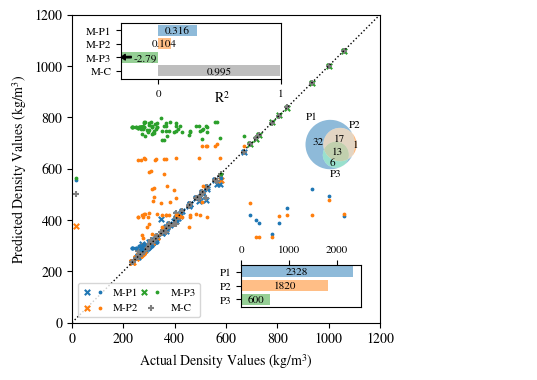

In [12]:
fig, ax1 = plt.subplots(figsize=(4,4))
samps = df[['compVec', 'density kg/m^3', 'provider']].sample(n=100, random_state=2)
compVecSamps = list(samps['compVec'])
actDens = list(samps['density kg/m^3'])
sampProvs = list(samps['provider'])

mkrSize1 = 15
mkrSize2 = 3
p = []
for idx, model in enumerate(models):
    if idx != 3:   
        p.append(ax1.scatter(samps['density kg/m^3'][samps['provider']==providerList[idx]],
                      model.predict(list(samps['compVec'][samps['provider']==providerList[idx]])),
                      s=mkrSize1, alpha=1, edgecolors=None, marker = 'x'))
    else:
        p.append(ax1.scatter(samps['density kg/m^3'],
                      model.predict(list(samps['compVec'])),
                      s=mkrSize1, alpha=1, edgecolors=None, marker = '+', fc='tab:grey'))

plt.gca().set_prop_cycle(None)
for idx, model in enumerate(models[:-1]):
    p.append(ax1.scatter(samps['density kg/m^3'][samps['provider']!=providerList[idx]],
                  model.predict(list(samps['compVec'][samps['provider']!=providerList[idx]])),
                  s=mkrSize2, alpha=1, edgecolors=None, marker = 'o'))


ax1.plot((0,1200), (0, 1200), 'k:', linewidth=1)

ax1.axis('tight')

ax1.set_ylabel('Predicted Density Values (kg/m$^3$)')
ax1.set_xlabel('Actual Density Values (kg/m$^3$)')
ax1.legend([(p[0], p[4]), (p[1], p[5]), (p[2], p[6]), p[3]], ['M-'+lab for lab in barLab],
           handler_map = {tuple: HandlerTuple(None)},
          loc='lower left', ncol=2, columnspacing=0.1, prop={'size': 8})
ax1.axis('equal')
ax1.axis('tight')
ax1.axis('square')
ax1.set_xlim(0, 1200)
ax1.set_ylim(0, 1200)

ax2 = fig.add_axes([0.25, 0.72, 0.4, 0.14])
p = ax2.barh(['M-'+lab for lab in barLab], rsq, color=colVals, alpha=0.5)

ax2.bar_label(p, [f'{rsq[0]:.3f}', f'{rsq[1]:.3f}', ''], fmt='%.3f', label_type='center', fontsize=8)
# ax2.bar_label(p, fmt='%.3f', label_type='center', fontsize=8)

ax2.text(-0.2, 2+0.26, f'{rsq[2]:.2f}', fontsize=8)
ax2.annotate('', xy=(-0.3, 2), xytext=(3, 1.5),
            arrowprops=dict(facecolor='k', ec = 'k', width=1, headwidth=4, headlength=3, shrink=0.975))
ax2.set_xlim(-0.3, 1)
ax2.set_xticks([0, 1])
ax2.set_xlabel('R$^2$')
ax2.xaxis.set_label_coords(0.63, -0.2)
ax2.tick_params(labelsize=8)
ax2.invert_yaxis()
# ax2.xaxis.tick_top()

# plt.show()
ax3 = fig.add_axes([0.7, 0.48, 0.15, 0.15])
v = vn.venn3([setElems[0], setElems[1], setElems[2]], barLab, set_colors=colVals, alpha=0.5, ax=ax3)
# ax.set_title('Unique elements')
plt.subplots_adjust(hspace=0.5)

# v.get_label_by_id('A').set_text(f'P1 ({len(y_train[0])+len(y_test[0])} Entries)')
# v.get_label_by_id('B').set_text(f'P2 ({len(y_train[1])+len(y_test[1])} Entries)')
# v.get_label_by_id('C').set_text(f'P3 ({len(y_train[2])+len(y_test[2])} Entries)')

v.get_label_by_id('A').set_text(f'P1')
v.get_label_by_id('B').set_text(f'P2')
v.get_label_by_id('C').set_text(f'P3')

ax4 = fig.add_axes([0.55, 0.15, 0.3, 0.14/4*3])
p = ax4.barh(barLab[:3], [len(y_train[i]+y_test[i]) for i in range(3)], color=colVals, alpha=0.5)
ax4.bar_label(p, fmt='%d', label_type='center', fontsize=8)
ax4.set_xlim(0,2.5e3)
ax4.tick_params(labelsize=8)
ax4.invert_yaxis()
ax4.xaxis.tick_top()

# v.get_label_by_id('A').set_x(0.5)
for text in v.set_labels:
    text.set_fontsize(8)
for text in v.subset_labels:
    try:
        text.set_fontsize(8)
    except:
        continue

plt.savefig('highEntropyExample.pdf', bbox_inches='tight')

# Draft plots

In [13]:
# fig, ax = plt.subplots(1, figsize=(1.5,1.5))
# # p = ax[0].barh(barLab, [len(y_train[idx])+len(y_test[idx]) for idx,_ in enumerate(y_test)], color=colVals, alpha=0.5)
# # ax[0].bar_label(p, fmt='%.2d', label_type='center')
# # ax[0].set_title('Number of materials')
# # ax[0].xaxis.tick_top()

# v = vn.venn3([setElems[0], setElems[1], setElems[2]], barLab, set_colors=colVals, alpha=0.5, ax=ax)
# # ax.set_title('Unique elements')
# plt.subplots_adjust(hspace=0.5)
# plt.savefig('countVenn.pdf', bbox_inches='tight')

# v.get_label_by_id('A').set_text(f'P1 ({len(y_train[0])+len(y_test[0])} Entries)')
# v.get_label_by_id('B').set_text(f'P2 ({len(y_train[1])+len(y_test[1])} Entries)')
# v.get_label_by_id('C').set_text(f'P3 ({len(y_train[2])+len(y_test[2])} Entries)')

# v.get_label_by_id('A').set_x(0.5)
# for text in v.set_labels:
#     text.set_fontsize(8)
# for text in v.subset_labels:
#     try:
#         text.set_fontsize(8)
#     except:
#         continue

In [14]:
# fig, ax = plt.subplots(figsize=(4,1))
# p = ax.barh([lab+' Model' for lab in barLab], rsq, color=colVals, alpha=0.5)
# ax.bar_label(p, fmt='%.2f', label_type='center')
# ax.text(0.02, 2-0.25, f'{rsq[2]:.2f}')
# ax.set_title('R$^2$')
# ax.set_xlim(0, 1)
# ax.xaxis.tick_top()

# # p = ax[0].barh(barLab, [len(y_train[idx])+len(y_test[idx]) for idx,_ in enumerate(y_test)], color=colVals, alpha=0.5)


In [15]:
# fig, ax = plt.subplots(2, figsize=(4,6), gridspec_kw={'height_ratios': [1.5, 4]})
# p = ax[0].barh([lab+' Model' for lab in barLab], rsq, color=colVals, alpha=0.5)
# ax[0].bar_label(p, fmt='%.2f', label_type='center')
# ax[0].text(0.02, 2-0.25, f'{rsq[2]:.2f}')
# ax[0].set_title('R$^2$')
# ax[0].set_xlim(0, 1)
# ax[0].xaxis.tick_top()


# samps = df[['compVec', 'density kg/m^3', 'provider']].sample(n=200, random_state=2)
# compVecSamps = list(samps['compVec'])
# actDens = list(samps['density kg/m^3'])
# sampProvs = list(samps['provider'])

# mkrSize1 = 20
# mkrSize2 = 5
# p = []
# for idx, model in enumerate(models):
#     if idx != 3:   
#         p.append(ax[1].scatter(samps['density kg/m^3'][samps['provider']==providerList[idx]],
#                       model.predict(list(samps['compVec'][samps['provider']==providerList[idx]])),
#                       s=mkrSize1, alpha=0.5, edgecolors=None, marker = 'x'))
#     else:
#         p.append(ax[1].scatter(samps['density kg/m^3'],
#                       model.predict(list(samps['compVec'])),
#                       s=mkrSize1, alpha=0.7, edgecolors=None, marker = 'x', fc='tab:grey'))

# plt.gca().set_prop_cycle(None)
# for idx, model in enumerate(models[:-1]):
#     p.append(ax[1].scatter(samps['density kg/m^3'][samps['provider']!=providerList[idx]],
#                   model.predict(list(samps['compVec'][samps['provider']!=providerList[idx]])),
#                   s=mkrSize2, alpha=0.5, edgecolors=None, marker = 'o'))


# ax[1].plot((0,1200), (0, 1200), 'k--', linewidth=1)

# ax[1].axis('tight')
# ax[1].set_xlim(0, 1200)
# ax[1].set_ylim(0, 1200)
# ax[1].set_ylabel('Predicted Density Values (kg/m$^3$)')
# ax[1].set_xlabel('Actual Density Values (kg/m$^3$)')
# ax[1].legend([(p[0], p[4]), (p[1], p[5]), (p[2], p[6]), p[3]], barLab, 
#           handler_map = {tuple: HandlerTuple(None)})
# # ax[1].legend(loc='upper left', ncol=2,columnspacing = 0, fontsize="small")
# # plt.subplots_adjust(hspace=0.3)
# ax[1].axis('equal')
# ax[1].axis('tight')
# ax[1].axis('square')

# # plt.savefig('scatterPlot.pdf', bbox_inches='tight')

In [16]:
# fig, ax = plt.subplots(2, figsize=(4,6), gridspec_kw={'height_ratios': [1.5, 4]})
# p = ax[0].barh(barLab, [len(y_train[idx])+len(y_test[idx]) for idx,_ in enumerate(y_test)], color=colVals, alpha=0.5)
# ax[0].bar_label(p, fmt='%.2d', label_type='center')
# ax[0].set_title('Number of materials')
# ax[0].xaxis.tick_top()

# vn.venn3([setElems[0], setElems[1], setElems[2]], barLab, set_colors=colVals, alpha=0.5, ax=ax[1])
# ax[1].set_title('Unique elements')
# plt.subplots_adjust(hspace=0.5)
# # plt.savefig('countVenn.pdf', bbox_inches='tight')

In [17]:
# plt.figure(figsize=(6, 10))
# ax = plt.subplot()
# for idx, dicts in enumerate(dictAllElem):
#     ax.barh(list(dicts.keys()), dicts.values(), alpha =0.5, label = barLab[idx], color=colVals[idx])
# ax.tick_params(axis='both', which='major', labelsize=10)
# ax.set_title('Frequecy of occourance of elements in each DB', fontweight='bold')
# plt.show()